In [1]:
from pathlib import Path
import pandas as pd

In [2]:
base_dir = Path().cwd().parent
processed_dir = base_dir/'data'/'processed'/'daily_report'

In [3]:
class DataLoader():
    def __init__(self):
        self.data = None
        self.day_range = None
        
    def _get_days(self, start_date, end_date):
        days = pd.date_range(start_date, end_date)
        self.day_range = days.strftime('%m-%d-%Y')    
        
    def load_data(self, data_path, start_date, end_date):
        self._get_days(start_date, end_date)
        
        self.data = pd.DataFrame()  

        for day in self.day_range:
            temp_data = pd.read_csv(data_path / f'{day}.csv')
            temp_data.loc[:, 'date'] = pd.to_datetime(day)
            self.data = self.data.append(temp_data)

In [32]:
class DataParser(DataLoader):

    def __init__(self):
        self.country = None

    def set_country(self, country=None):
        mask_country = self.data['country'] == country
        self.country = self.data[mask_country].copy()
        self.country = self.country.set_index('date').sort_index()

    def get_column_delta(self, column=None):
        shift_column = self.country[column].shift(1).squeeze()
        delta_column = self.country[column] - shift_column
        self.country.loc[:, f'{column}_delta'] = delta_column

    def get_moving_average(self, column=None, **kwargs):
        # get original column name
        colname = column.split('_')[0]
        
        df_ma = self.country[column].rolling(**kwargs).mean()
        self.country.loc[:, f'{colname}_moving_avg'] = df_ma

In [33]:
column_list = ['confirmed']

In [63]:
parser = DataParser()

parser.load_data(
    data_path=processed_dir,
    start_date='01/22/2020', 
    end_date='04/16/2020'
)

parser.set_country('Germany')
parser.country.head()

,country,confirmed,deaths,recovered,active
date,,,,,
2020-01-28,Germany,4.0,0.0,0.0,0.0
2020-01-29,Germany,4.0,0.0,0.0,0.0
2020-01-30,Germany,4.0,0.0,0.0,0.0
2020-01-31,Germany,5.0,0.0,0.0,0.0
2020-02-01,Germany,8.0,0.0,0.0,0.0


In [35]:
parser.get_column_delta('confirmed')
parser.get_moving_average('confirmed_delta', window=3, center=True)
parser.country.head()

,country,confirmed,deaths,recovered,active,confirmed_delta,confirmed_moving_avg
date,,,,,,,
2020-01-28,Germany,4.0,0.0,0.0,0.0,NaN,NaN
2020-01-29,Germany,4.0,0.0,0.0,0.0,0.0,NaN
2020-01-30,Germany,4.0,0.0,0.0,0.0,0.0,0.333333
2020-01-31,Germany,5.0,0.0,0.0,0.0,1.0,1.333333
2020-02-01,Germany,8.0,0.0,0.0,0.0,3.0,2.000000


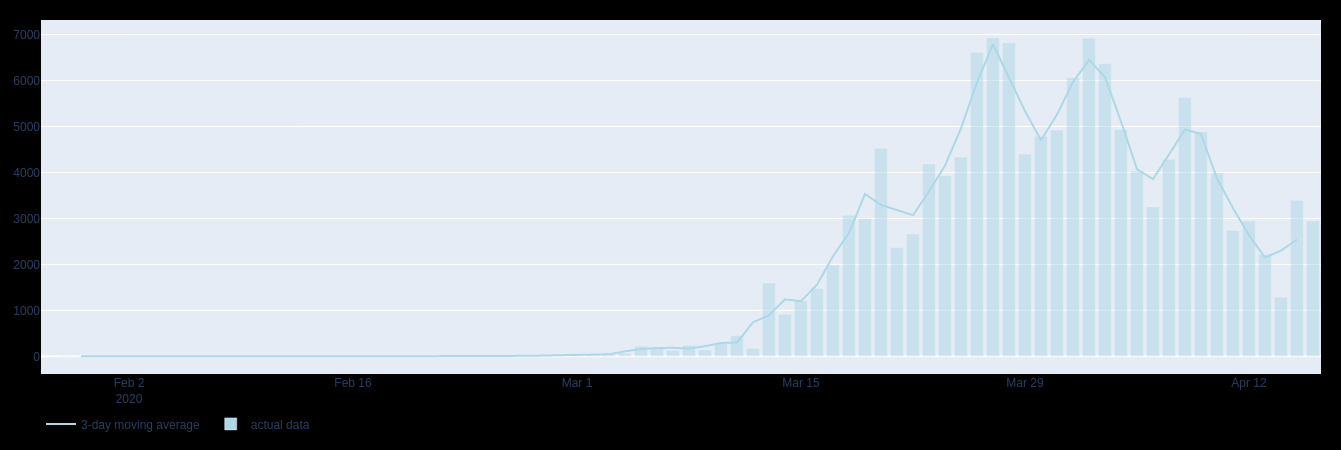

In [36]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure()

fig.update_layout(
    dict(
        width=800,
        height=450,
        legend_orientation='h',
        paper_bgcolor='rgba(0, 0, 0, 1)',
        margin=dict(t=20,l=20,r=20,b=20)
    )
)

scatter_trace = go.Scatter(
    name='3-day moving average',
    x=parser.country.index, 
    y=parser.country['confirmed_moving_avg'], 
    marker_color='lightblue',
    hoverinfo='skip'
)



bar_trace = go.Bar(
    name='actual data',
    x=parser.country.index, 
    y=parser.country['confirmed_delta'], 
    hoverinfo='y',
    marker=dict(
        color='lightblue',
        opacity=0.5,
    )
)

fig.add_trace(scatter_trace)
fig.add_trace(bar_trace)

fig.show()